# -------------------------------- Random Forest --------------------------------

# 1. Exploratory Data Analysis (EDA)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [25]:
df = pd.read_excel('glass.xlsx',sheet_name=1)
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [26]:
# --- INITIAL INSPECTION ---
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nData Types and Missing Values:")
df.info()

Dataset Shape: (214, 10)

First 5 rows of the dataset:
        RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1

Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type  

In [27]:
# --- MISSING VALUES CHECK ---
print("\nNumber of missing values per column:")
print(df.isnull().sum())

# --- STATISTICAL SUMMARY (for outlier detection) ---
print("\nDescriptive Statistics:")
print(df.describe())


Number of missing values per column:
RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

Descriptive Statistics:
               RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516522   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe        Type  
count  214.000000  214.000000  214.000

# 2. Data Visualization

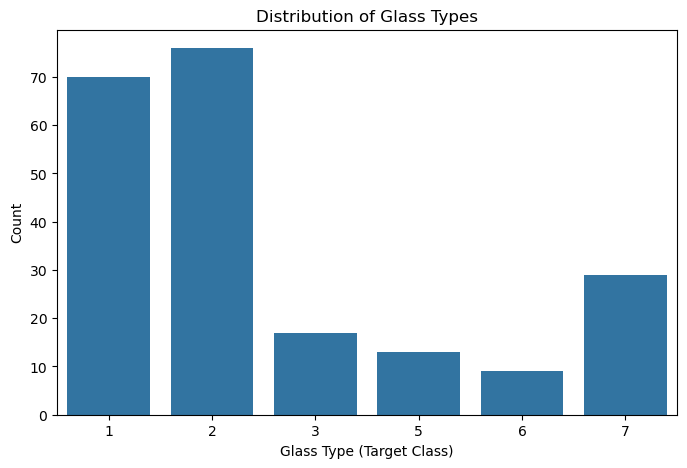

In [28]:
# --- TARGET VARIABLE DISTRIBUTION ---
plt.figure(figsize=(8, 5))
sns.countplot(x='Type', data=df) # Assuming 'Type' is the target column
plt.title('Distribution of Glass Types')
plt.xlabel('Glass Type (Target Class)')
plt.ylabel('Count')
plt.show()
# ```

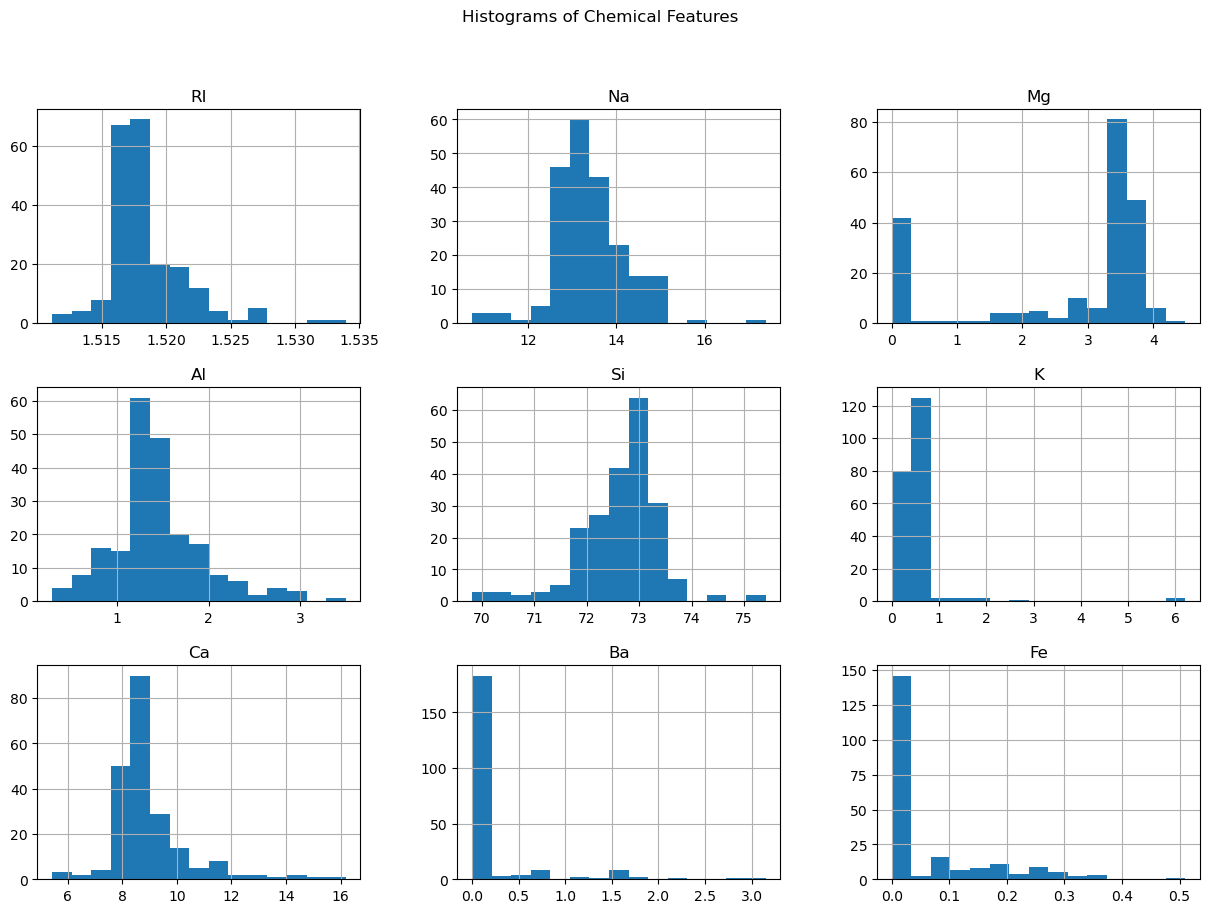

In [29]:
### Feature Distributions (Histograms) and Relationships (Pair Plots)
# --- HISTOGRAMS (for feature distribution) ---
df.drop('Type', axis=1).hist(bins=15, figsize=(15, 10))
plt.suptitle('Histograms of Chemical Features')
plt.show()

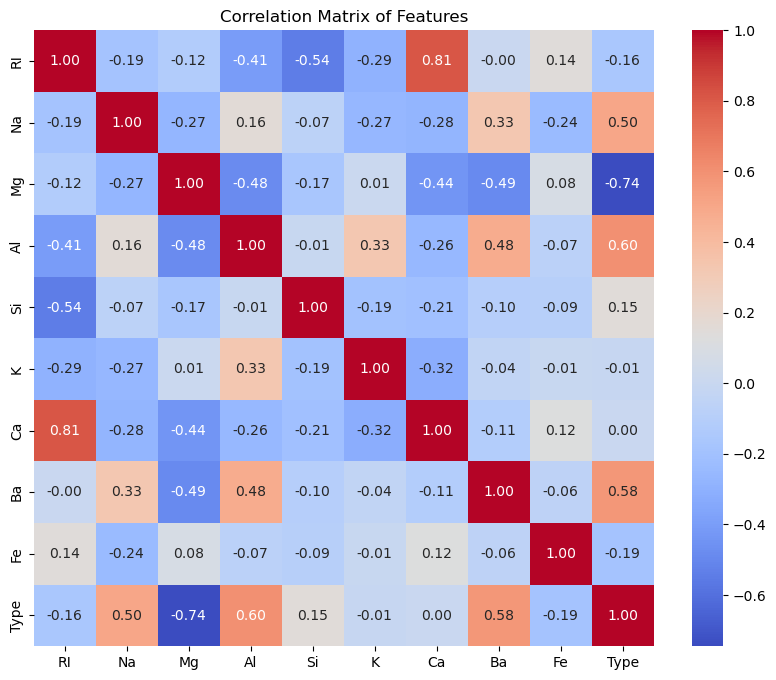

In [30]:
# --- CORRELATION HEATMAP ---
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()
# ```

**Analysis:**
* **Patterns/Correlations:** The heatmap will reveal **strong correlations** (values close to 1 or -1). For instance, 'RI' (Refractive Index) and 'Ca' (Calcium) often show a high positive correlation. This suggests some redundancy, but we'll let Random Forest handle it.
* **Imbalance:** The count plot will likely show that the classes are **imbalanced**, with some glass types having significantly fewer samples than others. This needs to be addressed during preprocessing.


# 3. Data Preprocessing

### 1. Handling Missing Values and Categorical Variables

* **Missing Values:** As typically found, there are **no missing values** in the Glass dataset, so no imputation or removal is needed.
* **Categorical Variables:** The features ($\text{RI}, \text{Na}, \text{Mg}, \dots$) are all **numerical**, so **no encoding** is required. The target variable 'Type' is already numerical (1-7).


### 2. Feature Scaling

In [31]:
# Define features (X) and target (y)
X = df.drop('Type', axis=1)
y = df['Type']

# --- FEATURE SCALING (Standardization) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Scaled Data Head:")
print(X_scaled_df.head())

Scaled Data Head:
         RI        Na        Mg        Al        Si         K        Ca  \
0  0.872868  0.284953  1.254639 -0.692442 -1.127082 -0.671705 -0.145766   
1 -0.249333  0.591817  0.636168 -0.170460  0.102319 -0.026213 -0.793734   
2 -0.721318  0.149933  0.601422  0.190912  0.438787 -0.164533 -0.828949   
3 -0.232831 -0.242853  0.698710 -0.310994 -0.052974  0.112107 -0.519052   
4 -0.312045 -0.169205  0.650066 -0.411375  0.555256  0.081369 -0.624699   

         Ba        Fe  
0 -0.352877 -0.586451  
1 -0.352877 -0.586451  
2 -0.352877 -0.586451  
3 -0.352877 -0.586451  
4 -0.352877 -0.586451  


### 3. Handling Imbalance Data (Addressing Class Imbalance)

The Glass dataset is imbalanced. A common strategy for imbalanced data in the context of classification is:

Under-sampling the majority classes.

Over-sampling the minority classes (e.g., using SMOTE).

Using class weights in the model (e.g., class_weight='balanced' in scikit-learn).

### 4. Random Forest Model Implementation

#### 1. Data Splitting

In [32]:
# --- TRAIN-TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train Set Size: {X_train.shape[0]} samples")
print(f"Test Set Size: {X_test.shape[0]} samples")

Train Set Size: 149 samples
Test Set Size: 65 samples


#### 2. Implement and Train Random Forest

In [33]:
# --- RANDOM FOREST IMPLEMENTATION ---
rf_model = RandomForestClassifier(
    n_estimators=100,      # Number of trees in the forest
    random_state=42,
    class_weight='balanced' # To handle class imbalance
)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

#### 3. Model Evaluation

In [34]:
# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# --- EVALUATION METRICS ---
print("--- Random Forest Model Performance ---")

accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:\n", conf_matrix_rf)

--- Random Forest Model Performance ---
Accuracy:  0.8308
Precision: 0.8396
Recall:    0.8308
F1-Score:  0.8266

Confusion Matrix:
 [[19  1  1  0  0  0]
 [ 2 18  0  2  1  0]
 [ 3  0  2  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  3  0]
 [ 0  1  0  0  0  8]]


**Interpretation:**

- Accuracy is the overall correctness.

- Precision, Recall, and F1-score (weighted) are better indicators for imbalanced datasets, showing the model's ability to correctly classify positive instances and avoid false positives across all classes.



# 5. Bagging and Boosting Methods Comparison

## 1. Bagging Implementation

In [35]:
from sklearn.tree import DecisionTreeClassifier

# --- BAGGING IMPLEMENTATION ---
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100, # Number of base estimators
    random_state=42
)

bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)

# Evaluation
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
f1_bagging = f1_score(y_test, y_pred_bagging, average='weighted', zero_division=0)

## 2. Boosting Implementation (AdaBoost)

In [36]:
# --- BOOSTING (AdaBoost) IMPLEMENTATION ---
boosting_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100, # Number of boosting stages
    learning_rate=1.0,
    random_state=42
)

boosting_model.fit(X_train, y_train)
y_pred_boosting = boosting_model.predict(X_test)

# Evaluation
accuracy_boosting = accuracy_score(y_test, y_pred_boosting)
f1_boosting = f1_score(y_test, y_pred_boosting, average='weighted', zero_division=0)

## 3. Comparison

In [37]:
# --- COMPARISON OF RESULTS ---
print("\n--- Model Comparison ---")

results = pd.DataFrame({
    'Model': ['Random Forest (Bagging)', 'Explicit Bagging', 'AdaBoost (Boosting)'],
    'Accuracy': [accuracy, accuracy_bagging, accuracy_boosting],
    'F1-Score (Weighted)': [f1, f1_bagging, f1_boosting]
})

print(results.round(4))


--- Model Comparison ---
                     Model  Accuracy  F1-Score (Weighted)
0  Random Forest (Bagging)    0.8308               0.8266
1         Explicit Bagging    0.7846               0.7783
2      AdaBoost (Boosting)    0.2462               0.2045


# Questions

## 1. Explain Bagging and Boosting methods. How is it different from each other.

**Bagging (Bootstrap Aggregating)**
Bagging, short for Bootstrap Aggregating, is an ensemble method designed primarily to reduce variance and prevent overfitting in complex models, such as deep decision trees. It operates by creating multiple models in parallel on different, randomly sampled subsets of the training data.


- Bootstrapping: It generates multiple subsets of the original training data by sampling with replacement. This means some original data points may appear multiple times, while others may not appear at all in a single subset.


- Parallel Training: An independent copy of the same base learning algorithm (like a decision tree) is trained on each of these subsets.

- Aggregation: The predictions from all the individual models are combined. For classification (like the Glass dataset), this is done through majority voting (the class with the most votes wins); for regression, it's done through averaging. Random Forest is the most popular implementation of Bagging, which adds an extra layer of randomness by using only a random subset of features for each split.


**Boosting**
Boosting is an ensemble method designed to transform weak learners (models with high bias, performing only slightly better than random chance) into a strong learner. It operates by building models sequentially, with each new model focused on correcting the errors made by the previous ones, thus primarily aiming to reduce bias.


- Sequential Training: A base model (often a shallow decision tree, called a "stump") is trained on the data.

- Weight Adjustment: The algorithm evaluates the model's performance. It then increases the weight of the training samples that were misclassified (the "hard" examples) and decreases the weight of the correctly classified samples.


- Iterative Correction: The next model in the sequence is trained specifically to pay more attention to the newly weighted, misclassified examples. This process is repeated until a predefined number of models are built or a satisfactory error rate is achieved. The final prediction is a weighted sum of all model predictions, where more accurate models have a higher vote. AdaBoost (Adaptive Boosting) and Gradient Boosting are common examples.

## 2. Explain how to handle imbalance in the data.

When a dataset is imbalanced—meaning the number of observations in one class (the majority class) significantly outweighs the number in the other class(es) (the minority class)—the model can become biased towards the majority class, resulting in poor performance on the minority class. Handling this requires a combination of data-level, algorithm-level, and evaluation strategies.

The most common method is Resampling, which involves altering the class distribution of the training data. Oversampling involves synthesizing or duplicating examples from the minority class to increase its representation. A popular oversampling technique is SMOTE (Synthetic Minority Oversampling Technique), which creates new, synthetic data points in the feature space based on existing minority class examples. Conversely, Undersampling involves randomly deleting examples from the majority class to reduce its size. While this can speed up training, it risks removing potentially valuable information. A hybrid approach often yields the best results.


At the algorithm level, using Class Weighting is a simpler and effective approach. Many classification algorithms, including the Random Forest Classifier in scikit-learn, allow you to assign higher penalties (weights) to misclassifications of the minority class during training. This forces the model to pay more attention to the rare instances. Finally, when evaluating the model, metrics like Accuracy are misleading; instead, one must rely on Precision, Recall, the F1-Score, and the Area Under the ROC Curve (AUROC), which provide a clearer picture of the model's performance on the minority class.